## Projective transform

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

%matplotlib inline

#### Step 1: reading & applying edge detection

In [2]:
from skimage import io
from skimage.feature import canny

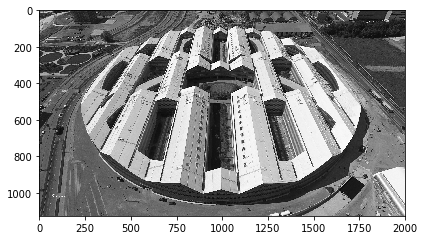

In [3]:
fname = './skoltech.jpg'
image_full = io.imread(fname, as_gray=True, plugin='matplotlib')
io.imshow(image_full)

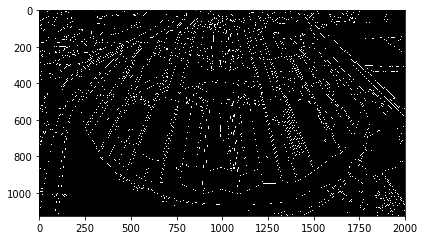

In [4]:
# here we can play with parameters
edges_full = canny(image_full, sigma=3)
io.imshow(edges_full)

####  The effect of downsampling

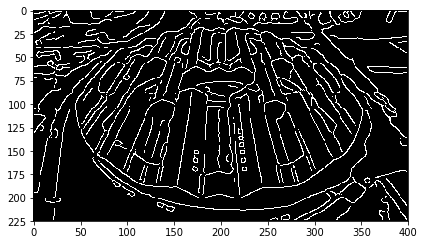

In [5]:
from skimage.transform import rescale
image_scaled = rescale(image_full, 0.2)
edges_scaled = canny(image_scaled, sigma=2)
io.imshow(edges_scaled)

It seems that the original image is a better choice for line detection

In [6]:
image, edges = image_full, edges_full
# image, edges = image_scaled, edges_scaled

### Step 2: run Hough 

In [7]:
from skimage.transform import hough_line, hough_line_peaks

In [8]:
# two auxilary functions
def get_line(a, b, x_lim, y_lim=None):
    x = np.linspace(*x_lim)
    y = a * x + b
    if y_lim is not None:
        y = y[y>=y_lim[0]]
        y = y[y<=y_lim[1]]
    return x, y

def hough_thetaro_to_ab(theta, ro):
    a = -1 /np.tan(theta)
    b = ro / np.sin(theta)
    return a, b

In [9]:
# all possible lines
h_all, theta_all, ro_all = hough_line(edges)

# automatically selected set of lines
# it could be a good idea to play with min_distance, min_angle, num_peaks
h_selected, theta_selected, ro_selected = hough_line_peaks(h_all, theta_all, ro_all)

#### Plot the detected lines
(and play with the parameters of hough_line_peaks if needed)

(1125, 0)

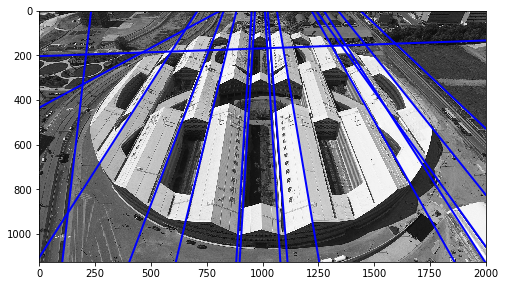

In [10]:
y_max, x_max = edges.shape

plt.figure(figsize = (8,5))
plt.imshow(image, cmap=cm.gray)
for theta, ro in zip(theta_selected, ro_selected):
    a, b = hough_thetaro_to_ab(theta, ro)
    plt.plot(*get_line(a, b, [0, x_max]), 'b', lw=2)

plt.xlim([0, x_max])
plt.ylim([y_max, 0])

## Step 3: Filter lines

 - We have a couple of noisy lines which must be removed before ProjectiveTransform.
 - We need a set lines with a common vanishing point to make them parallel. 
 - These lines must belong to a line in a-b Hough space and to a sin in theta-ro space. 

Text(0, 0.5, 'b')

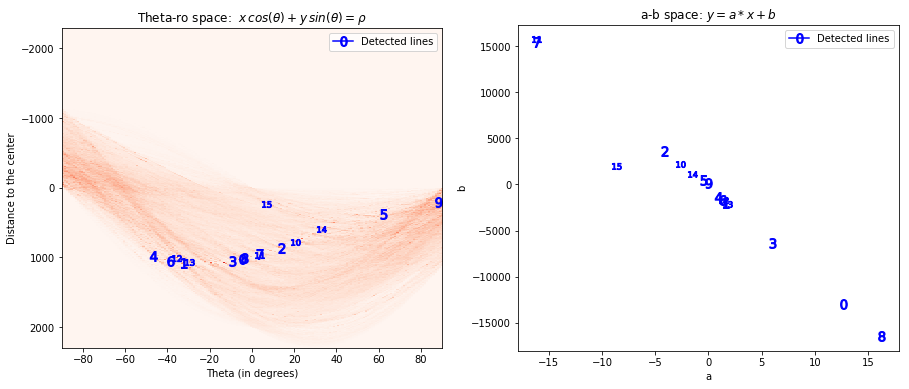

In [11]:
import itertools
markers = itertools.cycle(('s', '+', '^', 'o', '*')) 

fig, ax = plt.subplots(1, 2, figsize=(15, 6))
ax[0].imshow(h_all, cmap=cm.Reds, aspect=0.033,
             extent=[np.rad2deg(theta_all.min()), np.rad2deg(theta_all.max()), 
                                ro_all.max(), ro_all.min()],
             )

for i, (theta, ro) in enumerate(zip(theta_selected, ro_selected)):
    marker = '${}$'.format(i)
    ax[0].plot(np.rad2deg(theta), ro, 'b', marker=marker, ms=10)
    a, b = hough_thetaro_to_ab(theta, ro)
    ax[1].plot(a, b, 'b', marker=marker, ms=10)


ax[0].set_title(r'Theta-ro space:  $x\,cos(\theta)+ y\,sin(\theta)=\rho$')
ax[0].set_xlabel('Theta (in degrees)')
ax[0].set_ylabel('Distance to the center')
ax[0].legend(['Detected lines'])

ax[1].set_title(r'a-b space: $y = a*x + b$')
ax[1].legend(['Detected lines'])
ax[1].set_xlabel('a')
ax[1].set_ylabel('b')

#### We can use RANSAC algorithm to remove outliers

In [12]:
from skimage.measure import LineModelND, ransac

In [13]:
# convert all lines to a-b space
ab_selected = np.array(
    [hough_thetaro_to_ab(theta, ro)
     for theta, ro in zip(theta_selected, ro_selected)]
)

In [14]:
# look for inliers using a linear model
model, inliers = ransac(ab_selected, LineModelND, min_samples=5, residual_threshold=0.05)

Text(0, 0.5, 'b')

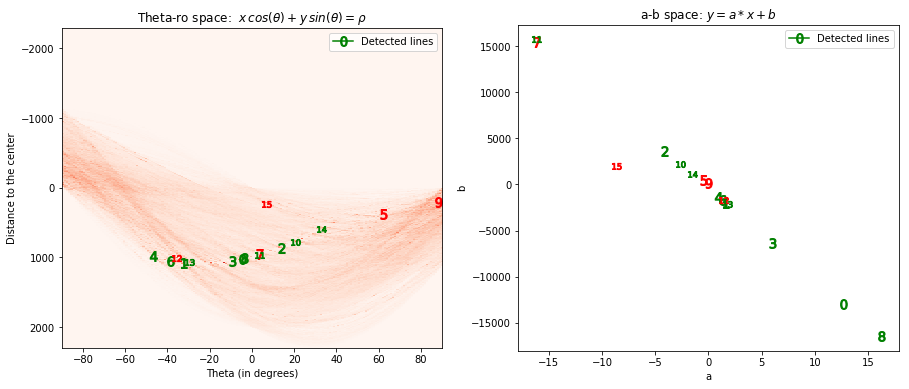

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
ax[0].imshow(h_all, cmap=cm.Reds, aspect=0.033,
             extent=[np.rad2deg(theta_all.min()), np.rad2deg(theta_all.max()), 
                                ro_all.max(), ro_all.min()],
             )

for i, (theta, ro) in enumerate(zip(theta_selected, ro_selected)):
    marker = '${}$'.format(i)
    color = 'g' if inliers[i] else 'r'
    ax[0].plot(np.rad2deg(theta), ro, color, marker=marker, ms=10)
    a, b = hough_thetaro_to_ab(theta, ro)
    ax[1].plot(a, b, color, marker=marker, ms=10)

    
ax[0].set_title(r'Theta-ro space:  $x\,cos(\theta)+ y\,sin(\theta)=\rho$')
ax[0].set_xlabel('Theta (in degrees)')
ax[0].set_ylabel('Distance to the center')
ax[0].legend(['Detected lines'])

ax[1].set_title(r'a-b space: $y = a*x + b$')
ax[1].legend(['Detected lines'])
ax[1].set_xlabel('a')
ax[1].set_ylabel('b')

(1125, 0)

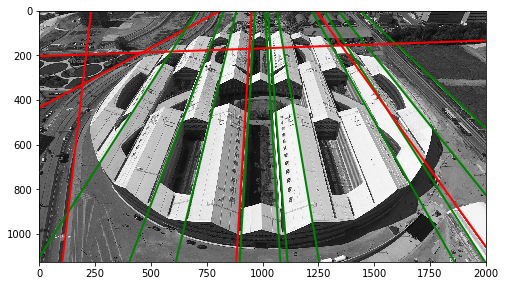

In [16]:
plt.figure(figsize = (8,5))
plt.imshow(image, cmap=cm.gray)
for i, (theta, ro) in enumerate(zip(theta_selected, ro_selected)):
    a, b = hough_thetaro_to_ab(theta, ro)
    color = 'g' if inliers[i] else 'r'
    plt.plot(*get_line(a, b, [0, x_max]), color, lw=2)

plt.xlim([0, x_max])
plt.ylim([y_max, 0])

## Step 4: Calculate the ProjectiveTransform

In [17]:
from skimage.transform import ProjectiveTransform, warp

In [18]:
lines_ab_final = ab_selected[inliers]

#### let us fix the coordinates of green lines for the bottom line (y=y_max) and make green lines ~~great~~ parallel again

In [19]:
points_current = []
points_desired = []
for i, ab in enumerate(lines_ab_final):
    # the points for the top of the image (y=0)
    x_0 = -ab[1] / ab[0]
    points_current.append([x_0, 0])
    points_desired.append([x_0, 0])
    # the points for the bottom of the image (y=y_max)
    points_current.append([(y_max - ab[1]) / ab[0], y_max])
    points_desired.append([x_0, y_max])
    
points_current = np.array(points_current)
points_desired = np.array(points_desired)

In [20]:
tform = ProjectiveTransform()
tform.estimate(points_desired, points_current)
image_warped = warp(image, tform)

(1125, 0)

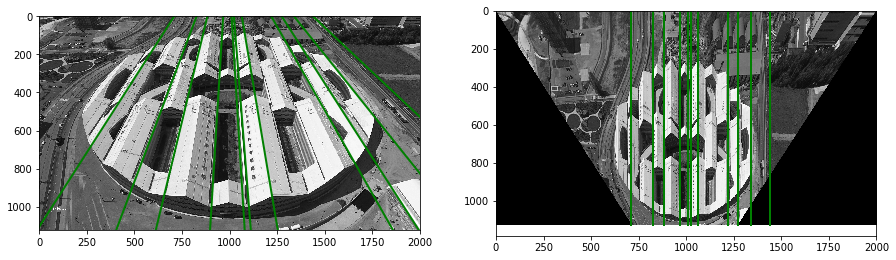

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(15, 9))
ax[0].imshow(image, cmap=cm.gray)
ax[1].imshow(image_warped, cmap=cm.gray)

for i in range(len(points_current)//2):
    ax[0].plot(*points_current[i*2:i*2+2].T, 'g', lw=2)
    ax[1].plot(*points_desired[i*2:i*2+2].T, 'g', lw=2)

ax[0].set_xlim([0, x_max])
ax[0].set_ylim([y_max, 0])

## Finally, plot the images in RGB

(1125, 187.5)

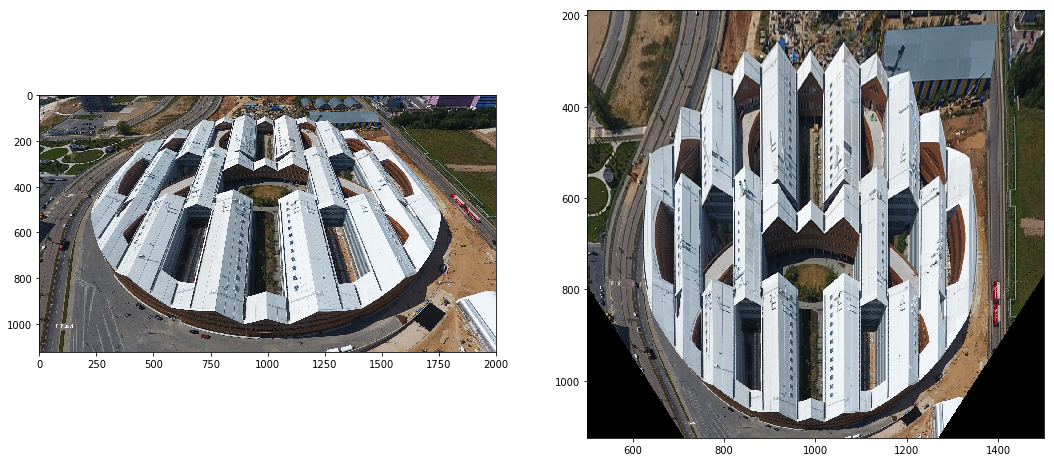

In [23]:
image_rgb = io.imread(fname, plugin='matplotlib')

fig, ax = plt.subplots(1, 2, figsize=(18, 9))
ax[0].imshow(image_rgb)
ax[1].imshow(warp(image_rgb, tform))

ax[0].set_xlim([0, x_max])
ax[0].set_ylim([y_max, 0])

ax[1].set_xlim([x_max * 0.25, x_max * 0.75])
ax[1].set_ylim([y_max, y_max/6])